# Convolutional Neural Networks Multi-Class Classification

This notebook contains the pipeline that allows to perform classification experiments of the Multi-Class version of this problem. **Cardboard**, **Metal**, **Paper**, **Glass**, and **Plastic** are the classes that are considered in this set of experiments. The used <u>data set</u> may be found in the following [Kaggle Repository](https://www.kaggle.com/asdasdasasdas/garbage-classification). 

NN_experimentation_notebook.ipynb set the baseline in order to work with in this notebook, the binary classification version of the problem is worked in there. In case of doubts, this should be the reference to be consulted.

# Imports

In [1]:
%%capture
# Import helper functions
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/file_management.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/evaluation_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
import os
import errno
import tensorflow as tf

# Helper functions
from helper_functions import create_tensorboard_callback, walk_through_dir
from file_management import bring_data, split_images, copy_folder
from evaluation_functions import (plot_loss_curves, evaluate_NN, 
                                  print_most_wrong_prediction)
                                  

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at /content/drive/


# Preprocessing
##Load the Data


In [3]:
path_list = ['/content/drive/MyDrive/PI2/data/cardboard.zip',
            '/content/drive/MyDrive/PI2/data/metal.zip',
             '/content/drive/MyDrive/PI2/data/glass.zip',
             '/content/drive/MyDrive/PI2/data/paper.zip',
             '/content/drive/MyDrive/PI2/data/plastic.zip']

# Unzip the data
bring_data(path_list=path_list)

# Split the dataset into train and test subsets
split_images(train_size=0.7, test_proportion=0.5)

# How many images/classes are there?
walk_through_dir("data")

Not found
Not found
There are 8 directories and 0 images in 'data'.
There are 0 directories and 482 images in 'data/plastic'.
There are 0 directories and 403 images in 'data/cardboard'.
There are 0 directories and 410 images in 'data/metal'.
There are 0 directories and 501 images in 'data/glass'.
There are 5 directories and 0 images in 'data/test'.
There are 0 directories and 142 images in 'data/test/plastic'.
There are 0 directories and 117 images in 'data/test/cardboard'.
There are 0 directories and 125 images in 'data/test/metal'.
There are 0 directories and 145 images in 'data/test/glass'.
There are 0 directories and 181 images in 'data/test/paper'.
There are 5 directories and 0 images in 'data/train'.
There are 0 directories and 246 images in 'data/train/plastic'.
There are 0 directories and 208 images in 'data/train/cardboard'.
There are 0 directories and 208 images in 'data/train/metal'.
There are 0 directories and 260 images in 'data/train/glass'.
There are 0 directories and 30

In [4]:
# Image paths
train_dir = '/content/data/train'
validation_dir = '/content/data/validation'
test_dir =  '/content/data/test'

IMG_SIZE = (224,224)
BATCH_SIZE = 32

# Load in the data
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

validation_data = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

Found 1225 files belonging to 5 classes.
Found 455 files belonging to 5 classes.
Found 710 files belonging to 5 classes.


## Define Early Stopping Callback

In [5]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=10)

## Define Data Augmentation Layer

In [6]:
# Create a Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    # preprocessing.RandomCrop(height=0.2,width=0.3), # Don't works for some reason
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomFlip(mode='vertical'),
    # preprocessing.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomTranslation(0.3,0.3),
    # preprocessing.RandomWidth(0.2),
    # preprocessing.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
    # layers.Rescaling(255.),
    tf.keras.layers.Resizing(224,224)
], name='data_augmentation_layer')

# Models

## CNN

In [7]:
cnn = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 4, activation='relu', padding='same', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(20, 3, activation='relu', padding='same', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Conv2D(15, 3, activation='relu', padding='same', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Conv2D(12, 3, activation='relu', padding='same', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu', padding='same', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax', name='output_layer')
])

# Compile the model
cnn.compile(loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            metrics=['accuracy'])

# Fit the model
cnn_history = cnn.fit(train_data,
                      epochs=50,
                      steps_per_epoch=len(train_data),
                      validation_data=validation_data,
                      batch_size=BATCH_SIZE*8,
                      validation_steps=len(validation_data),
                      callbacks=[create_tensorboard_callback(
                          dir_name='research_practice',
                          experiment_name='CNN'
                          ), earlystopping])

Saving TensorBoard log files to: research_practice/CNN/20211102-033026
Epoch 1/50
39/39 [==============================] - 48s 360ms/step - loss: 5.0728 - accuracy: 0.1935 - val_loss: 4.9830 - val_accuracy: 0.2418
Epoch 2/50
39/39 [==============================] - 12s 307ms/step - loss: 4.4497 - accuracy: 0.0000e+00 - val_loss: 3.9026 - val_accuracy: 0.2440
Epoch 3/50
39/39 [==============================] - 12s 305ms/step - loss: 3.9206 - accuracy: 0.0098 - val_loss: 3.8183 - val_accuracy: 0.2484
Epoch 4/50
39/39 [==============================] - 12s 305ms/step - loss: 3.8082 - accuracy: 0.0237 - val_loss: 3.7077 - val_accuracy: 0.2549
Epoch 5/50
39/39 [==============================] - 12s 304ms/step - loss: 3.6807 - accuracy: 0.0449 - val_loss: 3.5959 - val_accuracy: 0.2571
Epoch 6/50
39/39 [==============================] - 12s 306ms/step - loss: 3.5573 - accuracy: 0.0604 - val_loss: 3.4799 - val_accuracy: 0.2901
Epoch 7/50
39/39 [==============================] - 12s 305ms/step 

In [8]:
# Evaluate Model
cnn_results = cnn.evaluate(test_data)
cnn_results

23/23 [==============================] - 3s 112ms/step - loss: 1.0568 - accuracy: 0.3042


[1.056762456893921, 0.304225355386734]

# Evaluating Performance 

In [9]:
# Create Directory
root = 'experiments/'
destination = '/content/drive/MyDrive/PI2/experiments'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

Type Experiment Name: Test
Type Model Name: More Testing


## Plot Loss Curve

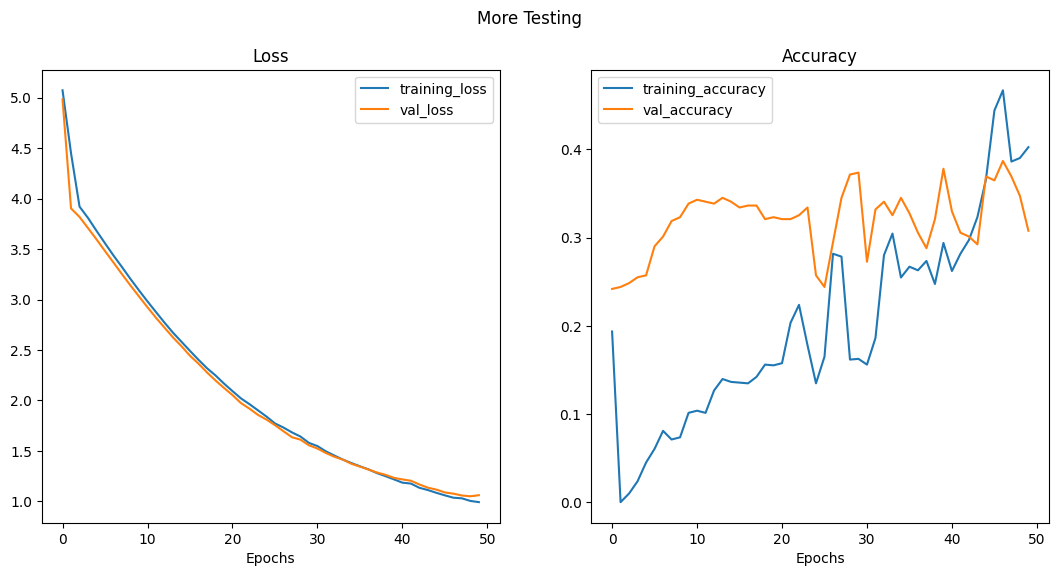

In [11]:
plot_loss_curves(cnn_history, model_name, path)

## Confusion Matrix and Score Barplots

23/23 [==============================] - 2s 80ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


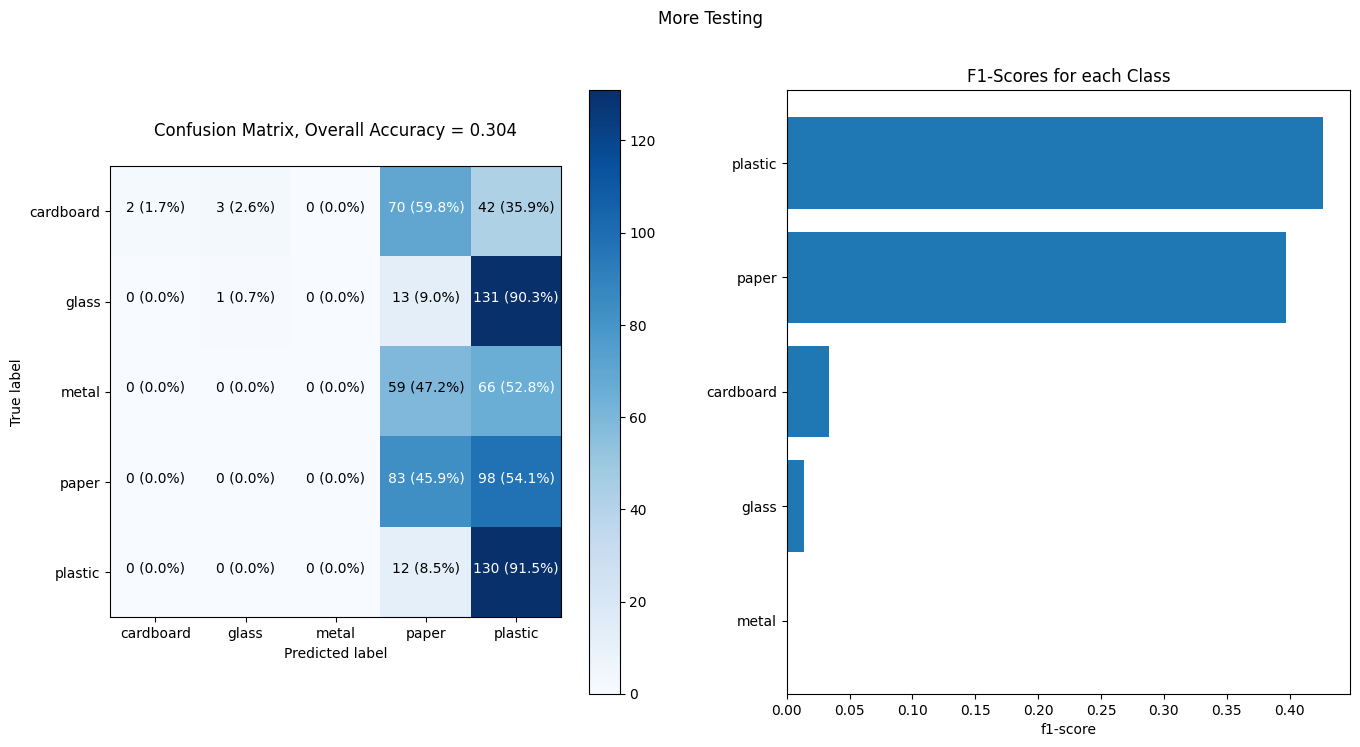

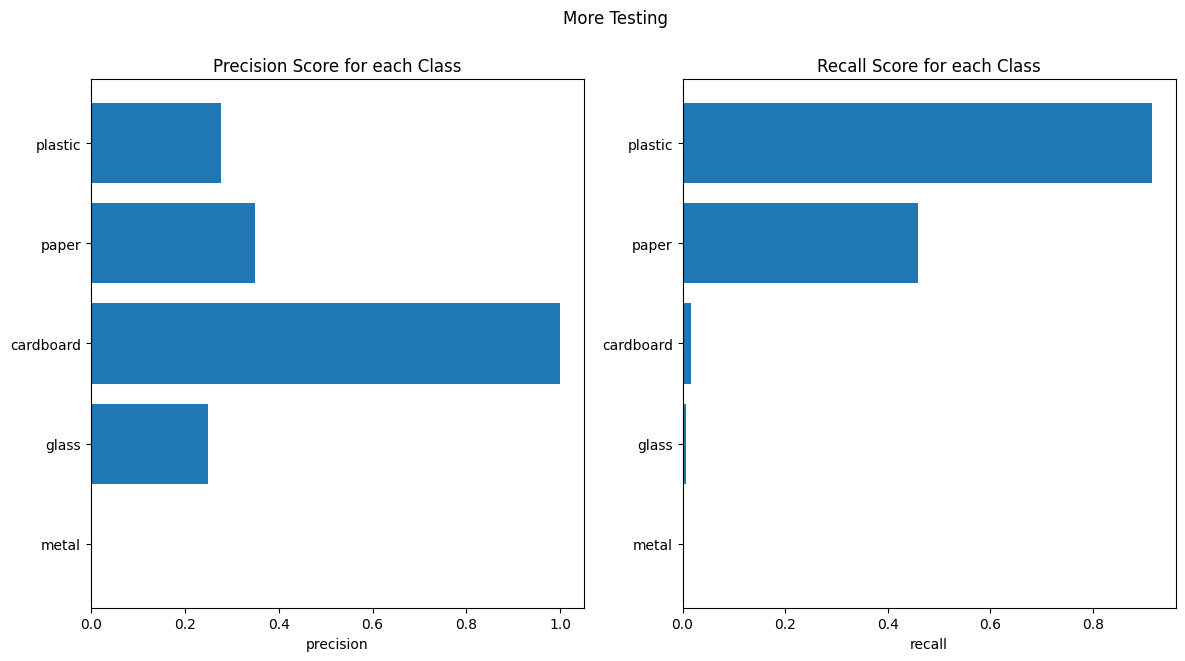

In [12]:
df_results, wrong_preds = evaluate_NN(cnn, test_data, 
                                      model_name, path)

## Print Most Wrong Predictions

In [13]:
print_most_wrong_prediction(wrong_preds, 10)

Output hidden; open in https://colab.research.google.com to view.

# Storing Results

In [ ]:
copy_folder(path, destination)

# Upload to TensorBoard Hub

In [ ]:
!tensorboard dev list

In [ ]:
!tensorboard dev upload --logdir /content/research_practice --name "Research Practice Model Experiments" --one_shot --description "Here are stored the results of the final models resulting from my research practice II. You can check the notebook where this was generated in https://github.com/daoterog/Solid_Domestic_Waste_Image_Classification" 